<a href="https://colab.research.google.com/github/rustambaku13/ML-Homework-2/blob/master/Homework_2_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import export_graphviz
import xgboost as xgb
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import cv2
import random
import matplotlib.image as mpimg
import os
from sklearn import svm
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2125, 0.7154 , 0.0721 ])

Using TensorFlow backend.


In [0]:
!pip install kaggle
!mkdir .kaggle
import json
import zipfile
token = {"username":"rustambaku13","key":"c6d933c6a18c4ce55d2a0da20c50daae"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
%pwd
!mkdir data
!kaggle competitions download -c aerial-cactus-identification -p data 


mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
mkdir: cannot create directory ‘data’: File exists
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
%cd data
zip_ref = zipfile.ZipFile("test.zip", 'r')
zip_ref.extractall()
zip_ref = zipfile.ZipFile("train.zip", 'r')
zip_ref.extractall()
zip_ref.close()

/content/data


In [0]:
x = list()
y = pd.read_csv("train.csv")
for index, row in y.iterrows():
  path = "train/"+row["id"]
  img = plt.imread(path) # and read created path
  img = cv2.resize(img,(40,40)) # resize image for lower processing power
  x.append(img) # append image to x data
  

id            000d1e9a533f62e55c289303b072733d.jpg
has_cactus                                       1
Name: 2, dtype: object

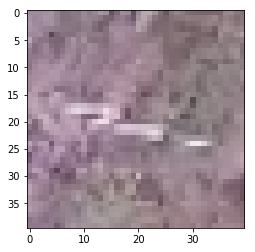

In [0]:
plt.subplot(1,1,1)
plt.imshow(x[2])
y.iloc[2]

In [0]:
y.drop(["id"], axis=1, inplace=True)
x = np.array(x)
y

,has_cactus
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,1
9,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [0]:

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(40,40,3),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(1, activation='sigmoid'))

In [0]:
fashion_model.summary()
fashion_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
fashion_train = fashion_model.fit(X_train,y_train, batch_size=128,epochs=5,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 40, 40, 32)        896       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 40, 40, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 128)       73856     
__________

In [0]:
test_eval = fashion_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 4.0304558996720745
Test accuracy: 0.7471861472377529


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')
new_fashion_model = Sequential()
new_fashion_model.add(model);
new_fashion_model.add(Dense(1, activation='sigmoid'))
new_fashion_model.summary()
new_fashion_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 25,637,713
Trainable params: 25,584,593
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
x = list()
y = pd.read_csv("train.csv")
for index, row in y.iterrows():
  path = "train/"+row["id"]
  img = plt.imread(path) # and read created path
  img = cv2.resize(img,(224,224)) # resize image for lower processing power
  x.append(img) # append image to x data

y.drop(["id"], axis=1, inplace=True)
x = np.array(x)
y  

**Similar to what has happened in part 2 Of the homework there is clash due to RAM overflow**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
new_fashion_model = new_fashion_model.fit(X_train,y_train, batch_size=128,epochs=5,verbose=1)

Epoch 1/5
